In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from math import radians, cos, sin, asin, sqrt
from pandas.tseries.holiday import USFederalHolidayCalendar

import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

In [2]:
# Read the train and test datasets
train_data = pd.read_csv('D:\\B.Tech\\project\\internship-project\\train.csv')
test_data = pd.read_csv('D:\\B.Tech\\project\\internship-project\\test.csv')

In [3]:
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
train_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [6]:
train_data[train_data.isna().any(axis=1)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


In [7]:
train_data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [8]:
# remove outliers for passenger_count 7,8,9,0
index = train_data[ (train_data['passenger_count'] == 7) | (train_data['passenger_count'] == 8) | (train_data['passenger_count'] == 9) | (train_data['passenger_count'] == 0)].index
train_data.drop(index , inplace=True)

In [9]:
# Remove outliers
mean = np.mean(train_data['trip_duration'])
print("Mean for Trip Duration is:", mean)

standard_deviation = np.std(train_data['trip_duration'])
print("Standard Deviation for Trip Duration is:", standard_deviation)

train_data = train_data[train_data['trip_duration'].between(mean - 2*standard_deviation, mean + 2*standard_deviation, inclusive = 'both')]
train_data.describe()

Mean for Trip Duration is: 959.4638466617166
Standard Deviation for Trip Duration is: 5237.070712268078


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.456476e+06,1.456476e+06,1.456476e+06,1.456476e+06,1.456476e+06,1.456476e+06,1.456476e+06
mean,1.534292e+00,1.663988e+00,-7.397349e+01,4.075093e+01,-7.397342e+01,4.075180e+01,8.368821e+02
std,4.988229e-01,1.313550e+00,7.091133e-02,3.286441e-02,7.067376e-02,3.588713e-02,6.589201e+02
min,1.000000e+00,1.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073736e+01,-7.399133e+01,4.073589e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075453e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396302e+01,4.076981e+01,1.073000e+03
max,2.000000e+00,6.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.141100e+04


In [10]:
# Data Formatting

train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].map(lambda x: 0 if x == 'N' else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].map(lambda x: 0 if x == 'N' else 1)

In [11]:
# Feature Extraction
# Decomposing timestamp for train data into date and time

train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pickup_date'] = train_data['pickup_datetime'].dt.date
train_data.loc[:, 'pickup_time'] = train_data['pickup_datetime'].dt.time
train_data['dropoff_datetime'] = pd.to_datetime(train_data.dropoff_datetime)
train_data.loc[:, 'dropoff_date'] = train_data['dropoff_datetime'].dt.date
train_data.loc[:, 'dropoff_time'] = train_data['dropoff_datetime'].dt.time
train_data.loc[:, 'dropoff_hour'] = train_data['dropoff_datetime'].dt.hour
train_data.loc[:, 'dropoff_weekday'] = train_data['dropoff_datetime'].dt.weekday
train_data.loc[:, 'dropoff_month'] = train_data['dropoff_datetime'].dt.month
train_data.loc[:, 'pickup_weekday'] = train_data['pickup_datetime'].dt.weekday

train_data['pickup_weekofyear'] = train_data['pickup_datetime'].dt.isocalendar().week

# train_data.loc[:, 'pickup_weekofyear'] = train_data['pickup_datetime'].dt.isocalendar().week
# train_data.loc[:, 'pickup_weekofyear'] = train_data['pickup_datetime'].dt.weekofyear
train_data.loc[:, 'pickup_hour'] = train_data['pickup_datetime'].dt.hour
train_data.loc[:, 'pickup_minute'] = train_data['pickup_datetime'].dt.minute
train_data.loc[:, 'pickup_dt'] = (train_data['pickup_datetime'] - train_data['pickup_datetime'].min()).dt.total_seconds()
train_data.loc[:, 'pickup_week_hour'] = train_data['pickup_weekday'] * 24 + train_data['pickup_hour']
train_data.loc[:, 'pickup_dayofyear'] = train_data['pickup_datetime'].dt.dayofyear
train_data.loc[:, 'pickup_month'] = train_data['pickup_datetime'].dt.month

In [12]:
# Feature Extraction
# Decomposing timestamp for test data into date and time

test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime)
test_data.loc[:, 'pickup_date'] = test_data['pickup_datetime'].dt.date
test_data.loc[:, 'pickup_time'] = test_data['pickup_datetime'].dt.time
test_data.loc[:, 'pickup_weekday'] = test_data['pickup_datetime'].dt.weekday

# train_data['pickup_weekofyear'] = train_data['pickup_datetime'].dt.isocalendar().week
train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'])

train_data.loc[:, 'pickup_weekofyear'] = train_data['pickup_datetime'].dt.isocalendar().week
# test_data.loc[:, 'pickup_weekofyear'] = test_data['pickup_datetime'].dt.weekofyear
test_data.loc[:, 'pickup_hour'] = test_data['pickup_datetime'].dt.hour
test_data.loc[:, 'pickup_minute'] = test_data['pickup_datetime'].dt.minute
test_data.loc[:, 'pickup_dt'] = (test_data['pickup_datetime'] - test_data['pickup_datetime'].min()).dt.total_seconds()
test_data.loc[:, 'pickup_week_hour'] = test_data['pickup_weekday'] * 24 + test_data['pickup_hour']
test_data.loc[:, 'pickup_dayofyear'] = test_data['pickup_datetime'].dt.dayofyear
test_data.loc[:, 'pickup_month'] = test_data['pickup_datetime'].dt.month

<ipython-input-12-2e326ea51b5f>:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_data.loc[:, 'pickup_weekofyear'] = train_data['pickup_datetime'].dt.isocalendar().week


In [13]:
# Feature Extraction
# Identifying holidays for train data from USFederalHolidayCalendar()

calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

train_data['pickup_holiday'] = pd.to_datetime(train_data.pickup_datetime.dt.date).isin(holidays)
train_data['pickup_holiday'] = train_data.pickup_holiday.map(lambda x: 1 if x == True else 0)
train_data['pickup_near_holiday'] = (pd.to_datetime(train_data.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) | pd.to_datetime(train_data.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
train_data['pickup_near_holiday'] = train_data.pickup_near_holiday.map(lambda x: 1 if x == True else 0)

In [14]:
# Identifying holidays for test data from USFederalHolidayCalendar()

test_data['pickup_holiday'] = pd.to_datetime(test_data.pickup_datetime.dt.date).isin(holidays)
test_data['pickup_holiday'] = test_data.pickup_holiday.map(lambda x: 1 if x == True else 0)
test_data['pickup_near_holiday'] = (pd.to_datetime(test_data.pickup_datetime.dt.date).isin(holidays + timedelta(days=1)) | pd.to_datetime(test_data.pickup_datetime.dt.date).isin(holidays - timedelta(days=1)))
test_data['pickup_near_holiday'] = test_data.pickup_near_holiday.map(lambda x: 1 if x == True else 0)

In [15]:
# Compute Distances using Longitudes & Latitudes

# 1 Haversine Distance
def haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# 2 Bearing Distance
def bearing_direction(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# 3 Manhattan Distance
def manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_distance(lat1, lng1, lat1, lng2)
    b = haversine_distance(lat1, lng1, lat2, lng1)
    return a + b


In [16]:
train_data.loc[:, 'direction'] = bearing_direction(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:, 'distance_haversine'] = haversine_distance(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:, 'distance_manhattan'] = manhattan_distance(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:, 'center_latitude'] = (train_data['pickup_latitude'].values + train_data['dropoff_latitude'].values) / 2
train_data.loc[:, 'center_longitude'] = (train_data['pickup_longitude'].values + train_data['dropoff_longitude'].values) / 2

In [17]:
test_data.loc[:, 'direction'] = bearing_direction(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)
test_data.loc[:, 'distance_haversine'] = haversine_distance(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)
test_data.loc[:, 'distance_manhattan'] = manhattan_distance(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)
test_data.loc[:, 'center_latitude'] = (test_data['pickup_latitude'].values + test_data['dropoff_latitude'].values) / 2
test_data.loc[:, 'center_longitude'] = (test_data['pickup_longitude'].values + test_data['dropoff_longitude'].values) / 2

In [18]:
google_distance_dataset = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/pizzarush-40b2f.appspot.com/o/train_with_distance848k.csv?alt=media&token=48501761-2b33-4508-9589-4ceb2eabe33d')
google_distance_dataset.head()

,Unnamed: 0,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,dropoff_day,dropoff_hour,dropoff_dayofweek,duration_time,distance_m,distance_km,pickup_date_isHoliday,dropoff_date_isHoliday,pickup_combined,google_distance
0,0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,...,14,17,0,< 5,1502.171837,1.502172,False,False,23464.246452,2005.0
1,1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,...,12,0,6,< 5,1808.659969,1.808660,False,False,23458.961021,2515.0
2,2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,...,19,12,1,5-10,6379.687175,6.379687,False,False,23463.529976,9916.0
3,3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,...,6,19,2,< 5,1483.632481,1.483632,False,False,23455.584686,1779.0
4,4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,...,26,13,5,< 5,1187.037659,1.187038,False,False,23468.804581,1607.0


In [19]:
google_distance = google_distance_dataset[:848000]['google_distance']
print(google_distance)

0         2005.0
1         2515.0
2         9916.0
3         1779.0
4         1607.0
           ...  
847995       NaN
847996    1078.0
847997    7621.0
847998    5521.0
847999    7938.0
Name: google_distance, Length: 848000, dtype: float64


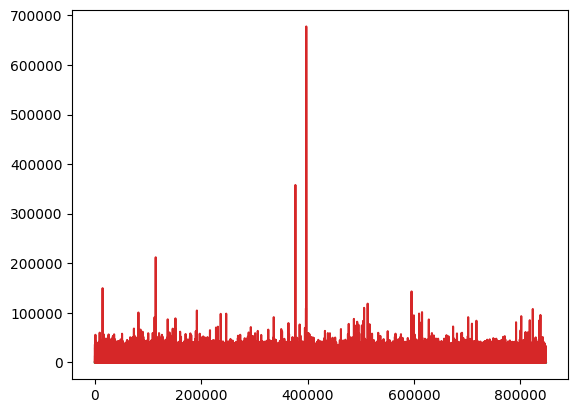

In [20]:
plt.figure()

x = list(range(848000))
y1 = train_data[:848000]['direction']
y2 = train_data[:848000]['distance_haversine']
y3 = train_data[:848000]['distance_manhattan']
y4 = google_distance

plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x, y3)
plt.plot(x, y4)

<Axes: >

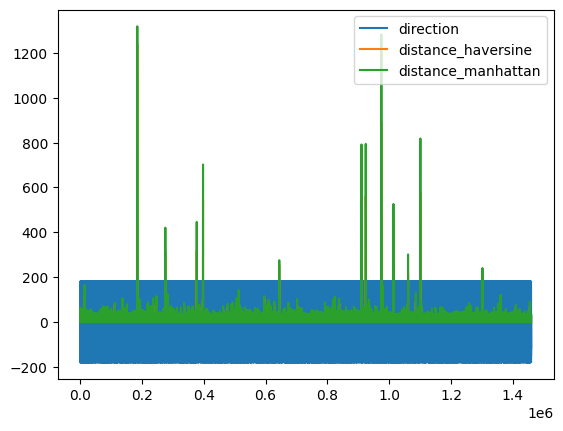

In [21]:
train_data[['direction', 'distance_haversine', 'distance_manhattan']].plot()

In [22]:
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_week_hour,pickup_dayofyear,pickup_month,pickup_holiday,pickup_near_holiday,direction,distance_haversine,distance_manhattan,center_latitude,center_longitude
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,17,74,3,0,0,99.970196,1.498521,1.735433,40.766769,-73.973392
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,144,164,6,0,0,-117.153768,1.805507,2.430506,40.734858,-73.989948
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,35,19,1,0,1,-159.680165,6.385098,8.203575,40.737013,-73.992180
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,67,97,4,0,0,-172.737700,1.485498,1.661331,40.713345,-74.011154
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,133,86,3,0,0,179.473585,1.188588,1.199457,40.787865,-73.972988


In [23]:
# Finding number of trips with 0 travelled distance which come out to be 5894.

train_data[(train_data['distance_haversine']==0)].count()

id                     5884
vendor_id              5884
pickup_datetime        5884
dropoff_datetime       5884
passenger_count        5884
pickup_longitude       5884
pickup_latitude        5884
dropoff_longitude      5884
dropoff_latitude       5884
store_and_fwd_flag     5884
trip_duration          5884
pickup_date            5884
pickup_time            5884
dropoff_date           5884
dropoff_time           5884
dropoff_hour           5884
dropoff_weekday        5884
dropoff_month          5884
pickup_weekday         5884
pickup_weekofyear      5884
pickup_hour            5884
pickup_minute          5884
pickup_dt              5884
pickup_week_hour       5884
pickup_dayofyear       5884
pickup_month           5884
pickup_holiday         5884
pickup_near_holiday    5884
direction              5884
distance_haversine     5884
distance_manhattan     5884
center_latitude        5884
center_longitude       5884
dtype: int64

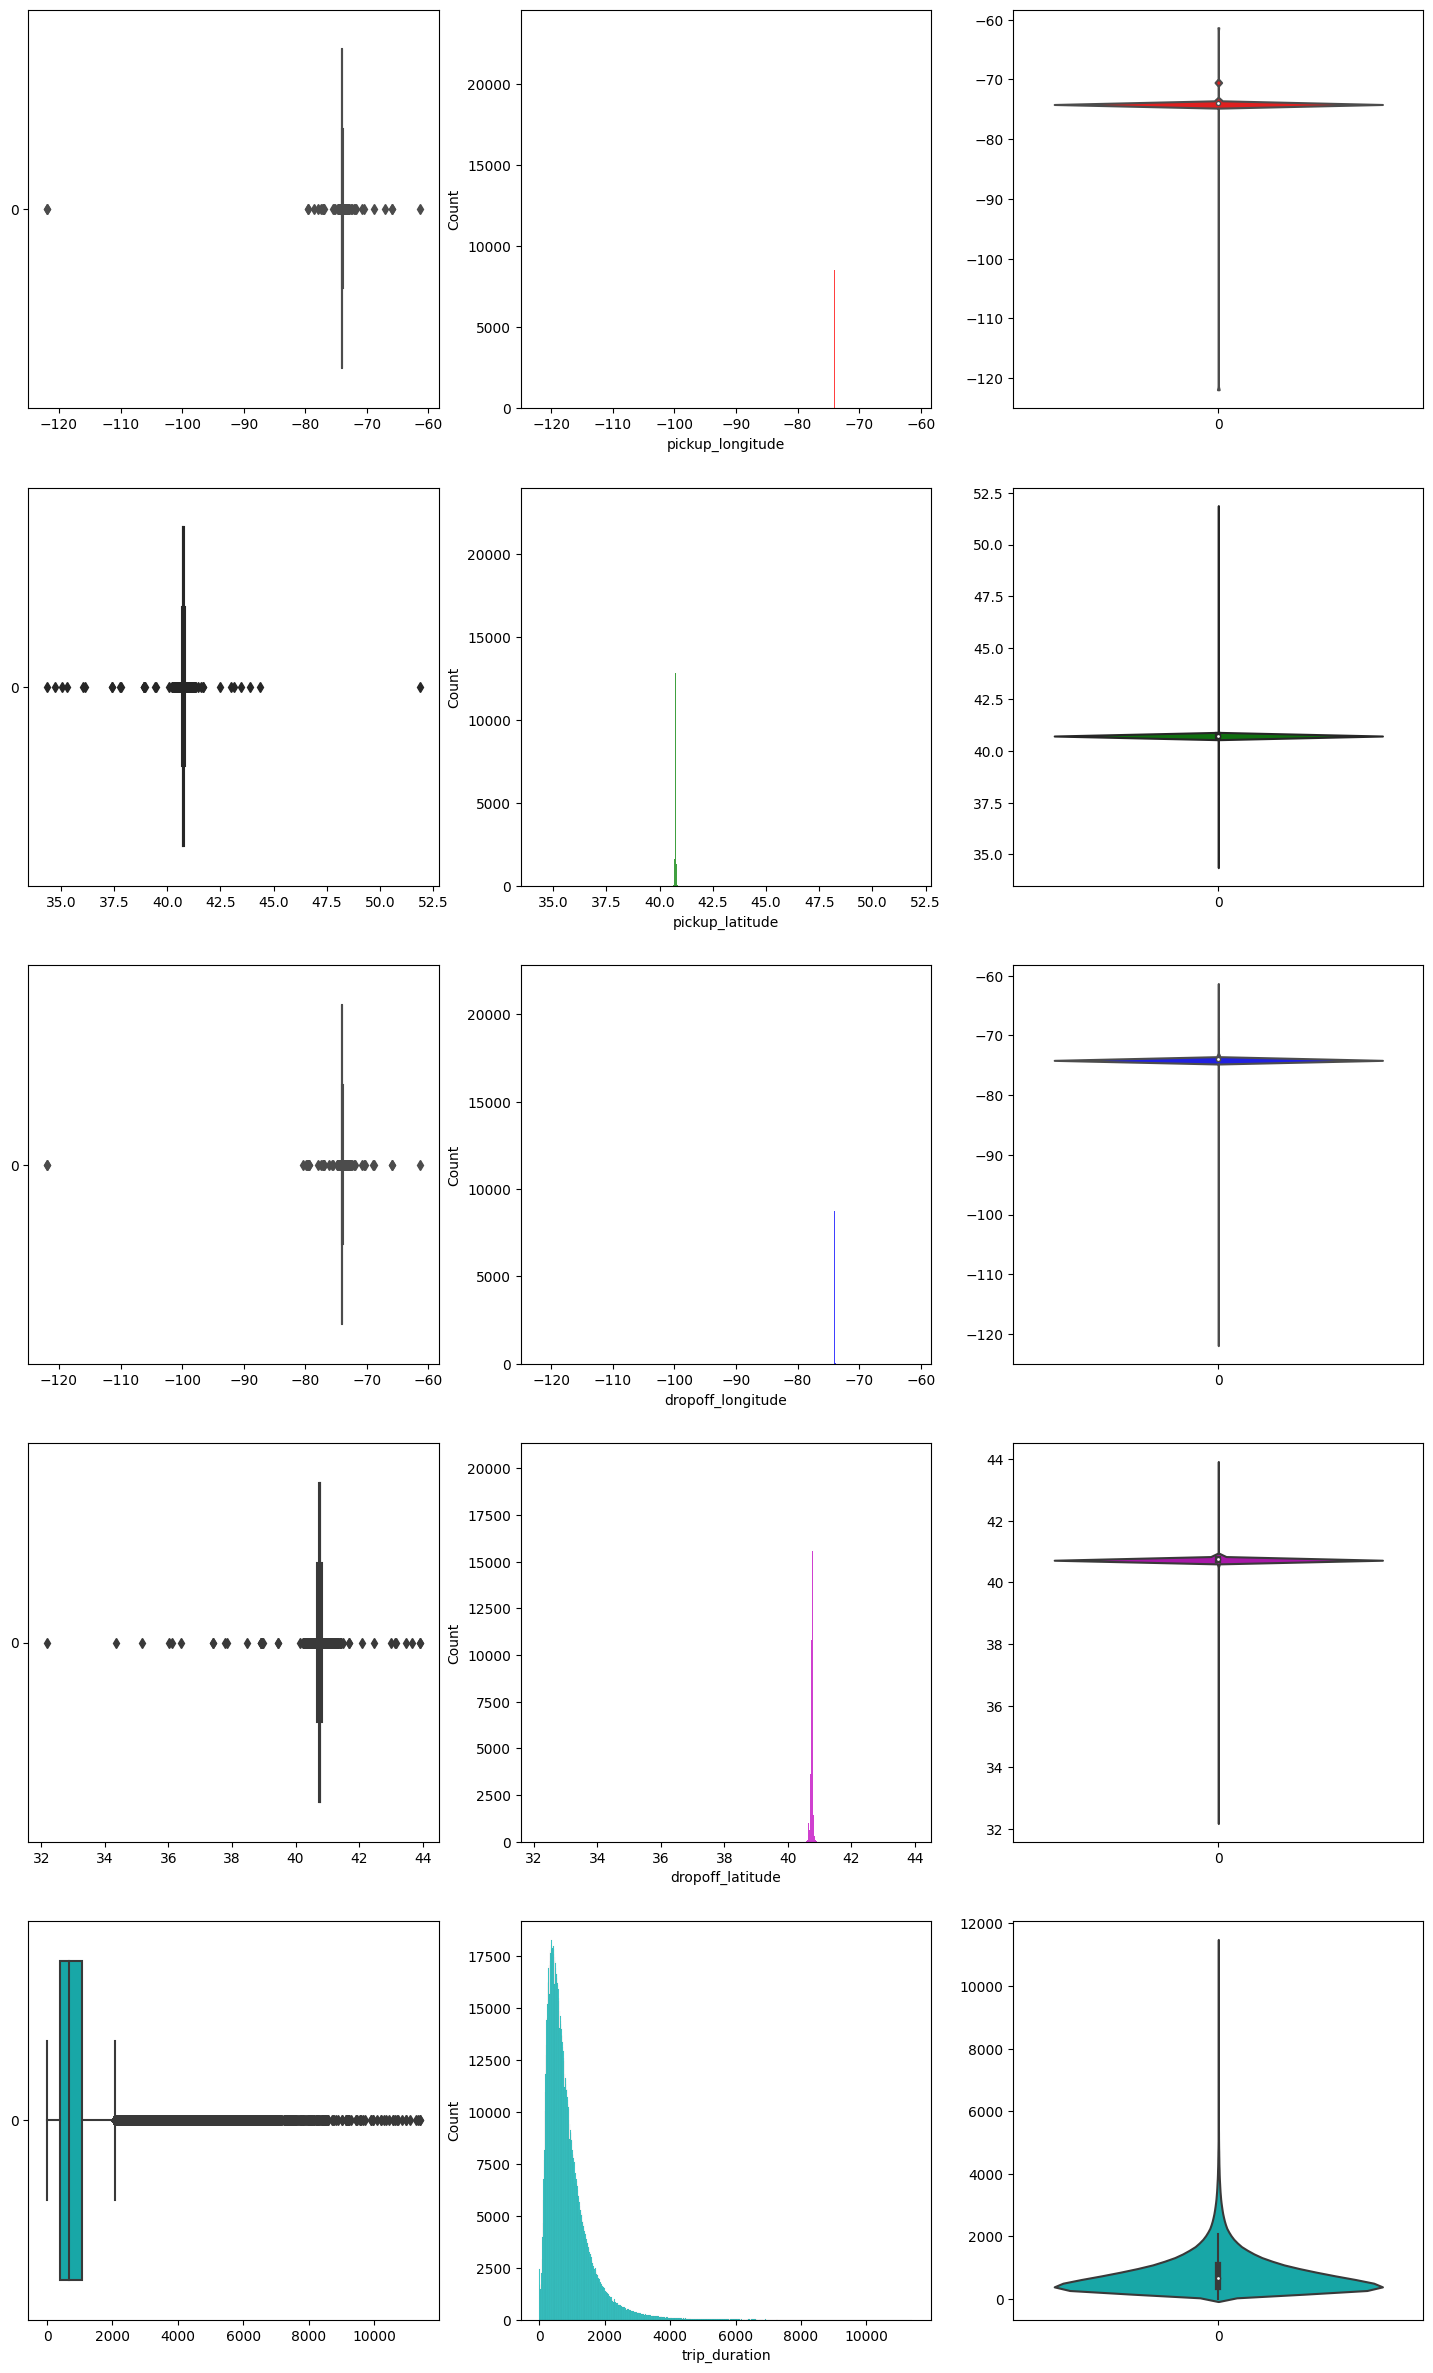

In [24]:
# Numeric Variables: Visualising using Box Plot, Dist Plot, Violin Plot
# pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_duration

numeric_data = pd.DataFrame(train_data[[
                                        'pickup_longitude',
                                        'pickup_latitude',
                                        'dropoff_longitude',
                                        'dropoff_latitude',
                                        'trip_duration',
                                        ]])

f, axes = plt.subplots(5, 3, figsize=(18, 30))
colors = ["r", "g", "b", "m", "c"]

count = 0
for var in numeric_data:
    sns.boxplot(numeric_data[var], orient = "h", color = colors[count], ax = axes[count,0])
    sns.histplot(numeric_data[var], color = colors[count], ax = axes[count,1])
    sns.violinplot(numeric_data[var], color = colors[count], ax = axes[count,2])
    count += 1

<Axes: xlabel='store_and_fwd_flag', ylabel='trip_duration'>

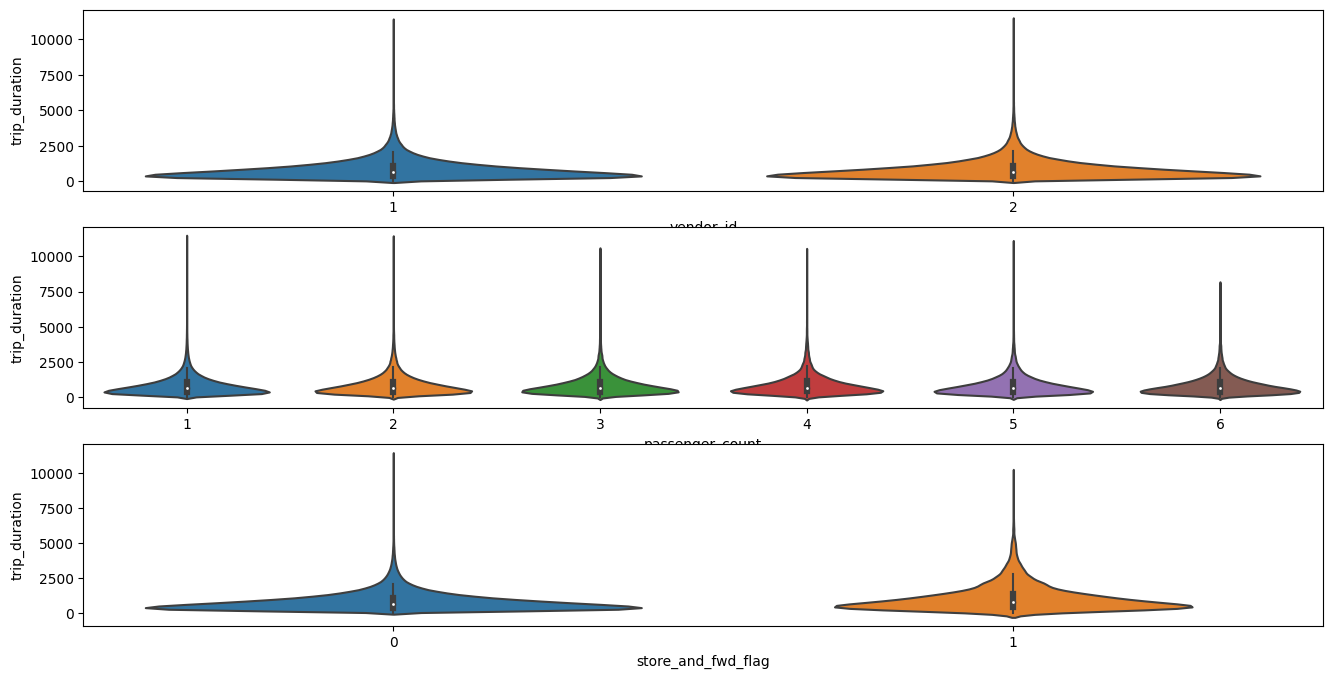

In [25]:
# Categorical Variables: Visualising using Violin Plots
# vendor_id, passenger_count, store_and_fwd_flag

f, axes = plt.subplots(3, 1, figsize=(16,8))

sns.violinplot(x = 'vendor_id', y = 'trip_duration', data = train_data, ax= axes[0])
sns.violinplot(x = 'passenger_count', y = 'trip_duration', data = train_data, ax= axes[1])
sns.violinplot(x = 'store_and_fwd_flag', y = 'trip_duration', data = train_data, ax= axes[2])

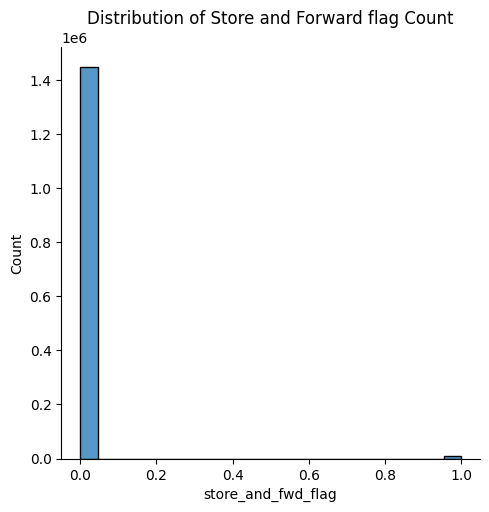

0    1448434
1       8042
Name: store_and_fwd_flag, dtype: int64

In [26]:
# Store and Forward Flag Distribution

sns.displot(train_data['store_and_fwd_flag'],kde=False)
plt.title('Distribution of Store and Forward flag Count')
plt.show()

train_data['store_and_fwd_flag'].value_counts()

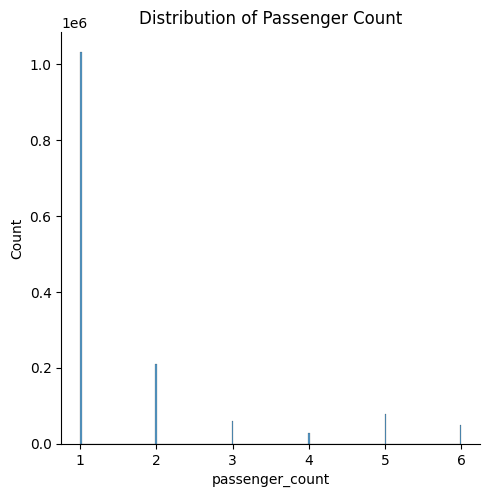

In [27]:
# Passenger Count Distribution

sns.displot(train_data['passenger_count'],kde=False)
plt.title('Distribution of Passenger Count')
plt.show()

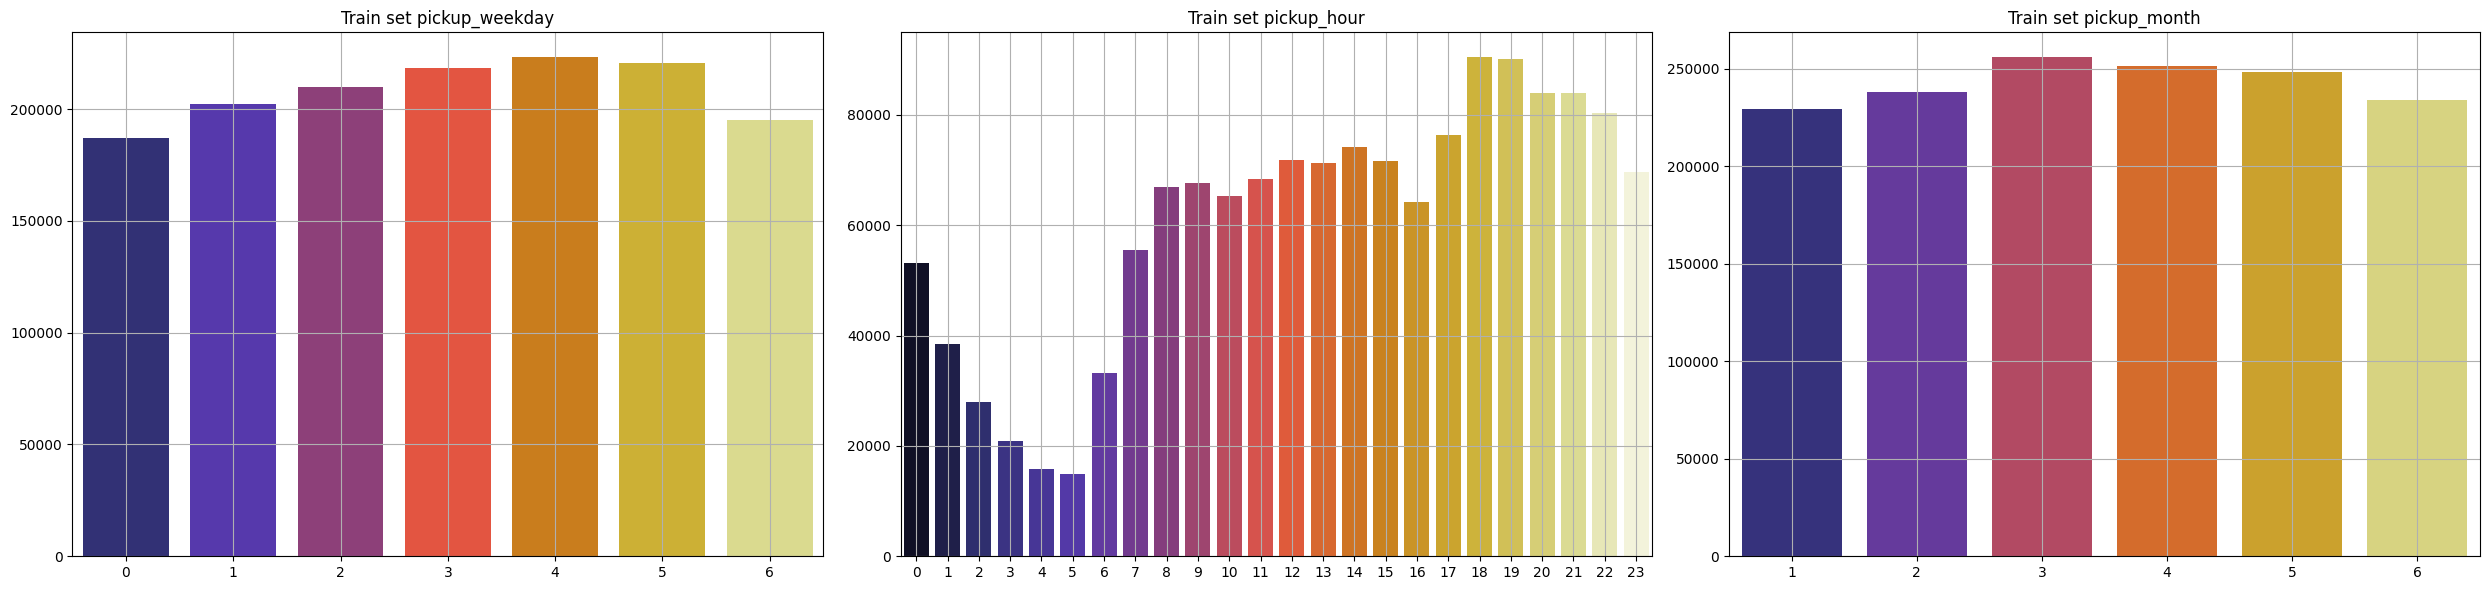

In [28]:
# Count of occurences of each pickup day, pickup hour and pickup month

fig, sub = plt.subplots(1,3,figsize=(25,6))
counter = 0
# train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'])
# train_data['pickup_weekday'] = train_data['pickup_datetime'].dt.weekday
train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'])
train_data['pickup_hour'] = train_data['pickup_datetime'].dt.hour
train_data['pickup_month'] = train_data['pickup_datetime'].dt.month

for feat, subplot in zip(["pickup_weekday","pickup_hour", "pickup_month"], sub.flatten()):

    if counter < 3:
        sns.barplot(x=train_data[feat].value_counts().index, y = train_data[feat].value_counts().values, ax= subplot, palette="CMRmap")
        subplot.grid()
        subplot.set_title("Train set {}".format(feat))

    counter+=1

fig.tight_layout()

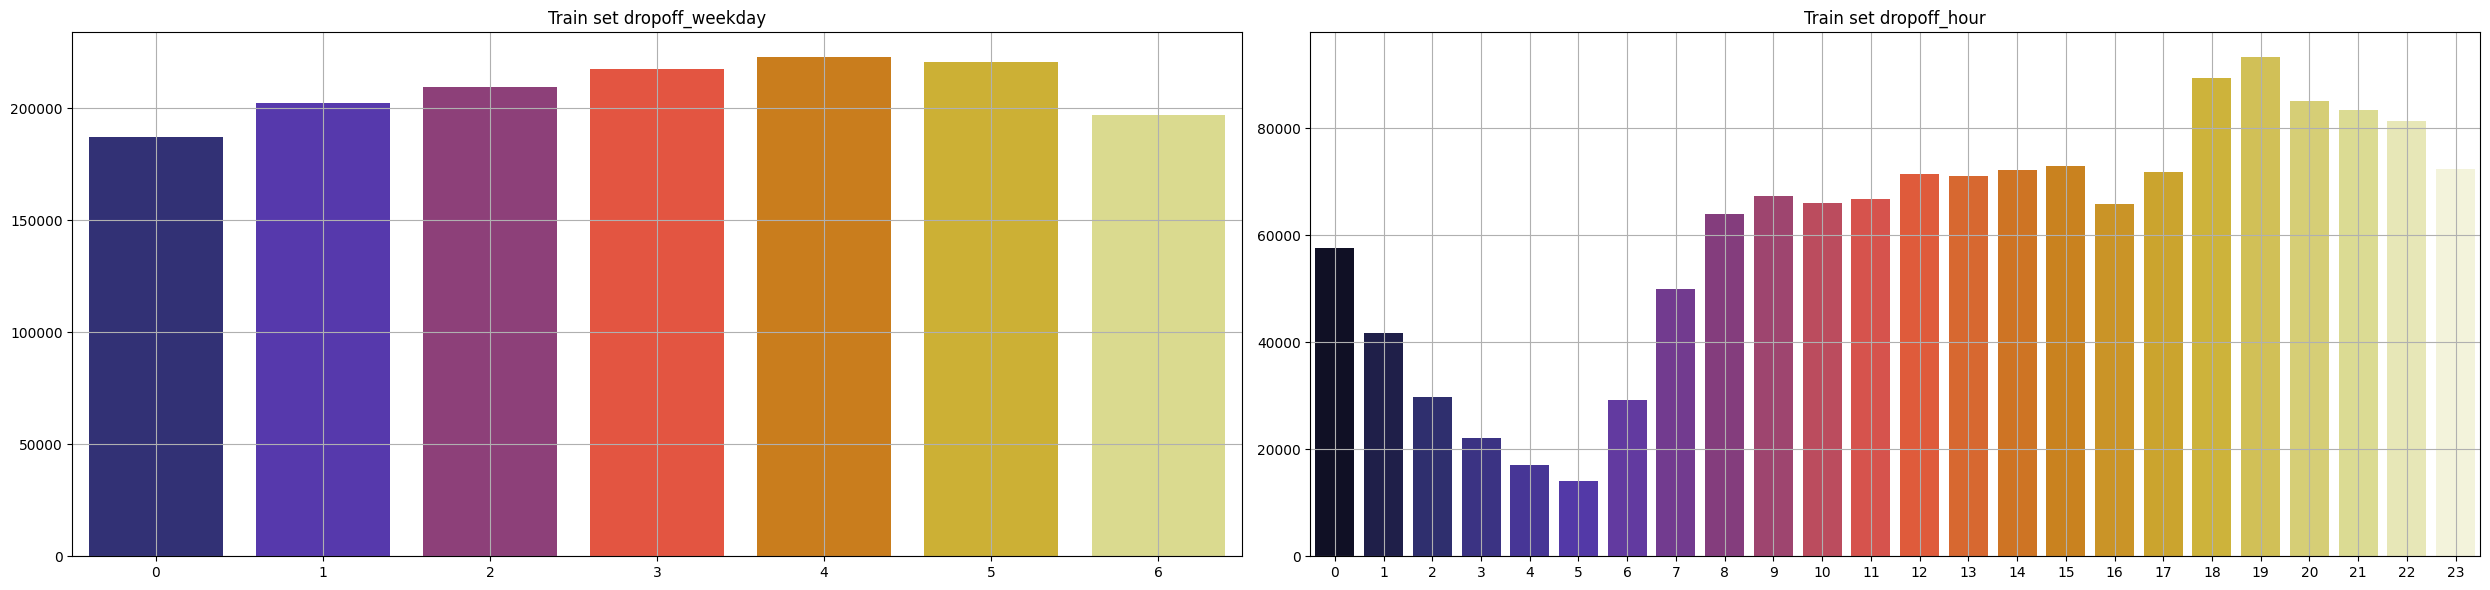

In [29]:
# Count of occurences of each dropoff weekday and dropoff hour
# dropoff month has been excluded since the pickup month and dropoff month would be in the same month

fig, sub = plt.subplots(1,2,figsize=(25,6))
counter = 0
train_data['dropoff_datetime'] = pd.to_datetime(train_data['dropoff_datetime'])
train_data['dropoff_weekday'] = train_data['dropoff_datetime'].dt.weekday
train_data['dropoff_hour'] = train_data['dropoff_datetime'].dt.hour

for feat, subplot in zip(["dropoff_weekday","dropoff_hour"], sub.flatten()):

    if counter < 2:
        sns.barplot(x=train_data[feat].value_counts().index, y = train_data[feat].value_counts().values, ax= subplot, palette="CMRmap")
        subplot.grid()
        subplot.set_title("Train set {}".format(feat))

    counter+=1

fig.tight_layout()

[Text(0.5, 0, 'Trip duration in seconds'), Text(0, 0.5, 'Trip Count')]

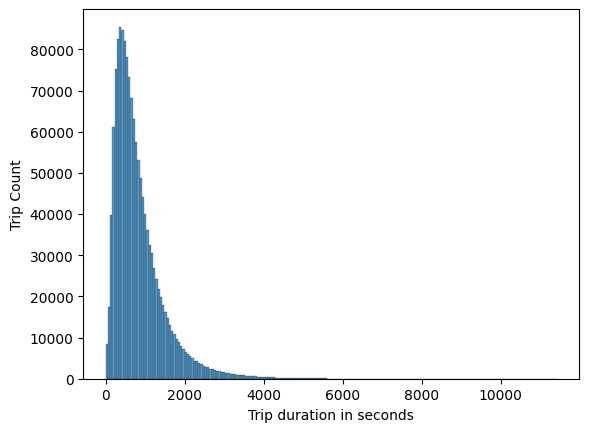

In [30]:
# Histogram to visualise counts for each Trip Duration

graph = sns.histplot(train_data["trip_duration"], bins = 200)
graph.set(xlabel='Trip duration in seconds', ylabel='Trip Count')

[Text(0.5, 0, 'Trip duration in seconds (Normalised)'),
 Text(0, 0.5, 'Trip Count')]

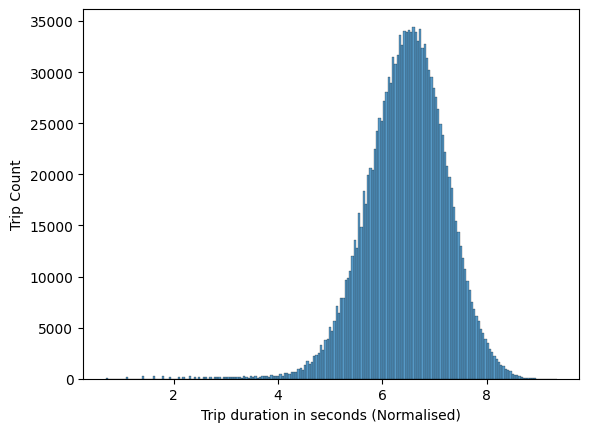

In [31]:
# Histogram to visualise counts for each Trip Duration, with logarithmic normalisation/scaling

train_data['trip_duration_normalised'] = np.log(train_data['trip_duration'].values + 1)
graph = sns.histplot(train_data["trip_duration_normalised"], bins = 200)
graph.set(xlabel='Trip duration in seconds (Normalised)', ylabel='Trip Count')

In [32]:
# Visualise Trips Count by Pick Up date

fig = go.Figure()
train_data['pickup_datetime'] = pd.to_datetime(train_data['pickup_datetime'])
train_data['pickup_date'] = train_data['pickup_datetime'].dt.date

pickup_date_count = pd.DataFrame(train_data.groupby('pickup_date').count()[['id']])
pickup_date_count.index.name = 'Pickup Dates'
pickup_date_count.reset_index(inplace=True)


fig.add_trace(go.Scatter(x=pickup_date_count['Pickup Dates'], y=pickup_date_count['id'],
                    mode='lines+markers',
                    name='lines+markers'))

fig.update_xaxes(title_text="Pickup Months")
fig.update_yaxes(title_text="Count of Trips")

<ipython-input-33-ecf7a96a9572>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



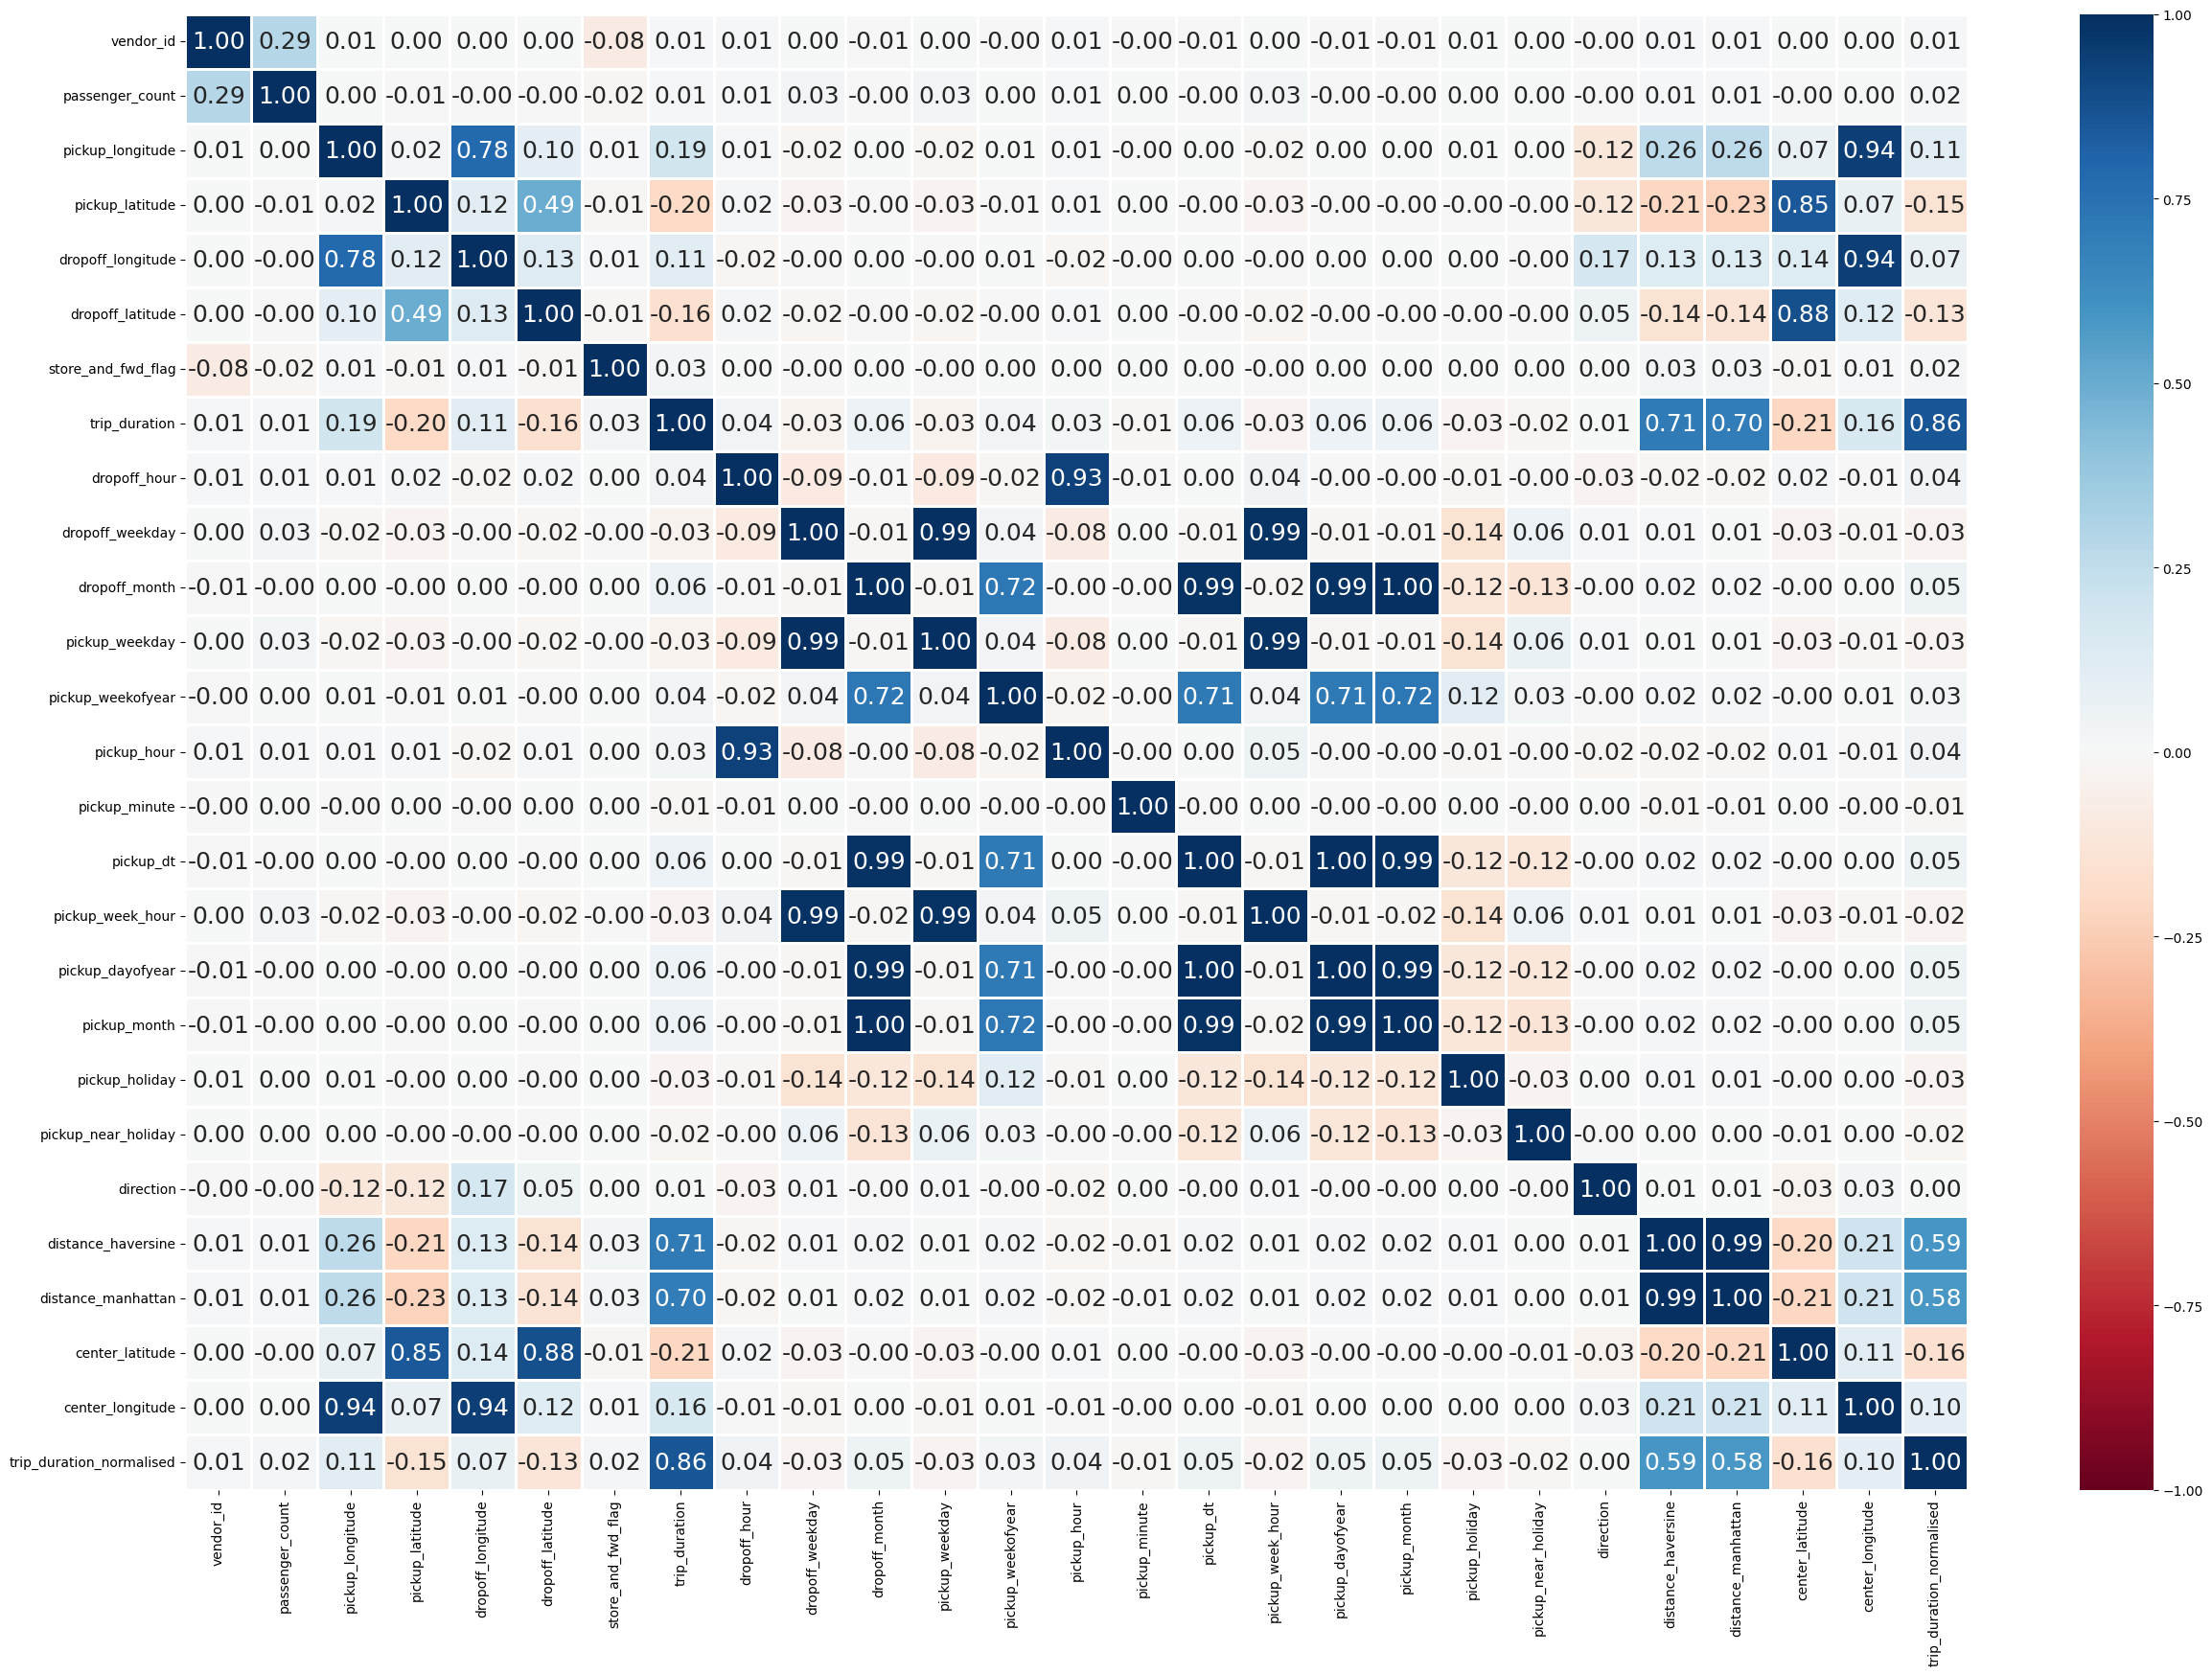

In [33]:
# Heap Map to visualise Feature Correlation

f, axes = plt.subplots(1, 1, figsize=(20, 20))
sns.heatmap(train_data.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")
f.set_figwidth(30)

<Axes: xlabel='vendor_id', ylabel='Time in Seconds'>

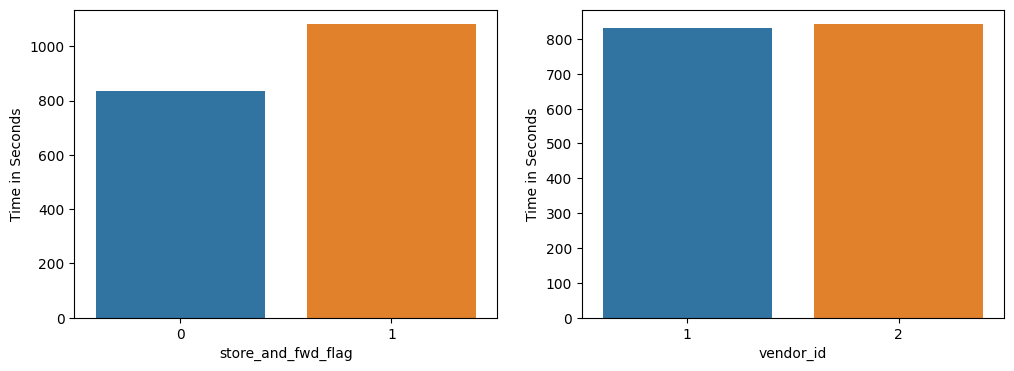

In [34]:
# Average Trip Duration VS Store-and-Forward Flag and Average Trip Duration VS Vendor ID

fig, ax = plt.subplots(ncols=2, figsize=(12,4))

# Average Trip Duration VS Store-and-Forward Flag

store_and_fwd_flag_df = train_data.groupby('store_and_fwd_flag')['trip_duration'].mean()
plt.ylabel('Time in Seconds')
sns.barplot(x=store_and_fwd_flag_df.index, y=store_and_fwd_flag_df.values, ax=ax[0])
plt.setp(ax[0], ylabel='Time in Seconds')

# Average Trip Duration VS Vendor ID

vendor_id_df = train_data.groupby('vendor_id')['trip_duration'].mean()
plt.ylabel('Time in Seconds')
sns.barplot(x=vendor_id_df.index, y=vendor_id_df.values, ax=ax[1])



<Axes: xlabel='passenger_count', ylabel='Time in Seconds'>

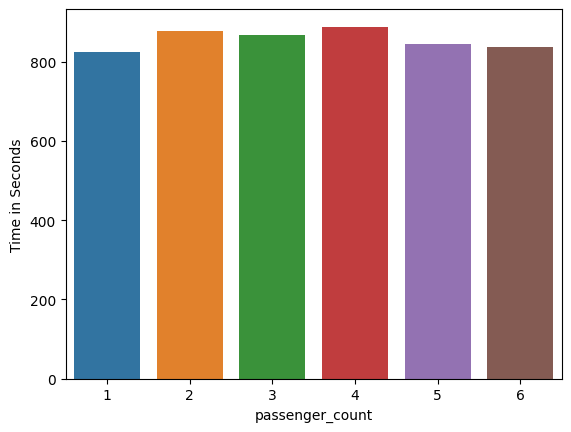

In [35]:
# Passenger Count VS Trip Duration time in seconds

passenger_count_df = train_data.groupby('passenger_count')['trip_duration'].mean()
plt.ylabel('Time in Seconds')
# sns.barplot(passenger_count_df.index, passenger_count_df.values)
sns.barplot(x=passenger_count_df.index, y=passenger_count_df.values)


<Axes: xlabel='passenger_count', ylabel='Trip Distance in KM'>

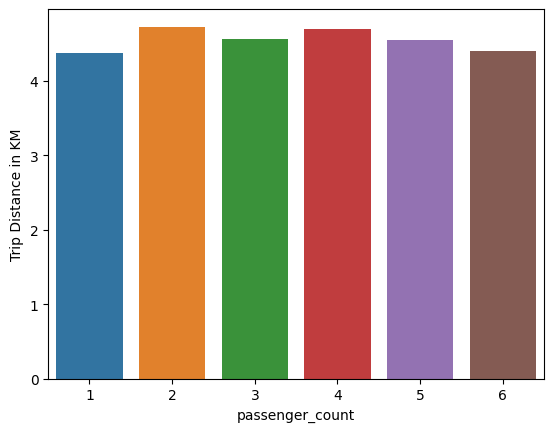

In [36]:
# Passenger Count VS Trip Distance

passenger_count_distance_df = train_data.groupby('passenger_count')['distance_manhattan'].mean()
plt.ylabel('Trip Distance in KM')
sns.barplot(x=passenger_count_distance_df.index, y=passenger_count_distance_df.values)

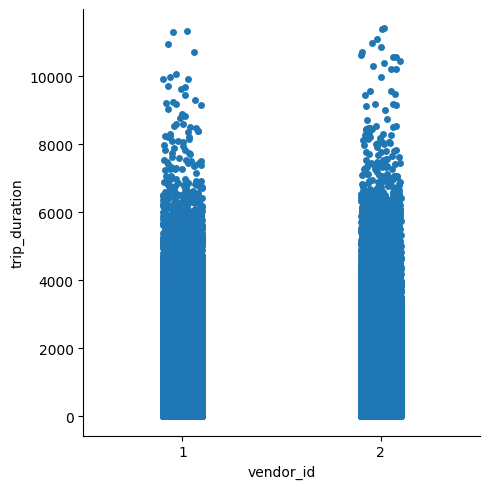

In [37]:
# Relationship b/w Vendor ID and Trip Duration

sns.catplot(x="vendor_id", y="trip_duration",kind="strip",data=train_data)

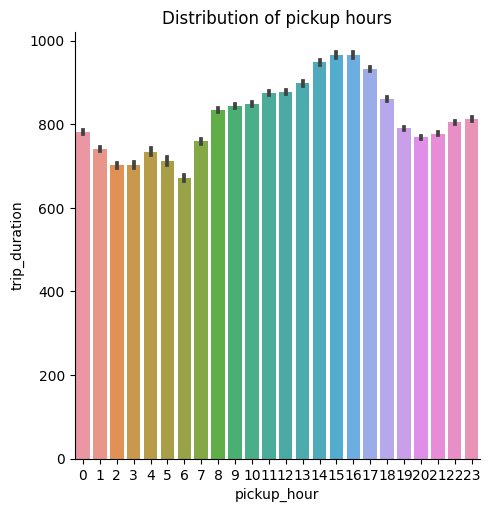

In [38]:
# Relationship b/w Trip Duration and Time of Day

ax=sns.catplot(x="pickup_hour", y="trip_duration",kind="bar",data=train_data)
plt.title('Distribution of pickup hours')
plt.show()

Text(0.5, 1.0, 'The Average Trip Duration per PickUp Day of the Week')

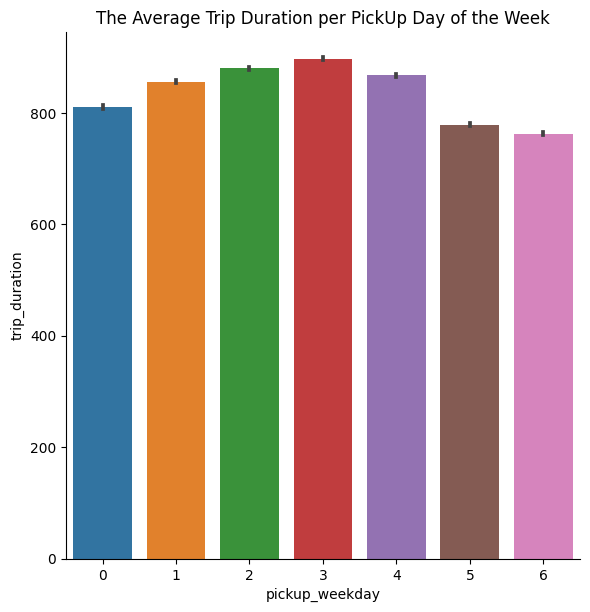

In [39]:
# Relationship b/w Trip Duration and Day of Week

sns.catplot(x="pickup_weekday",y="trip_duration",kind="bar",data=train_data,height=6,aspect=1)
plt.title('The Average Trip Duration per PickUp Day of the Week')

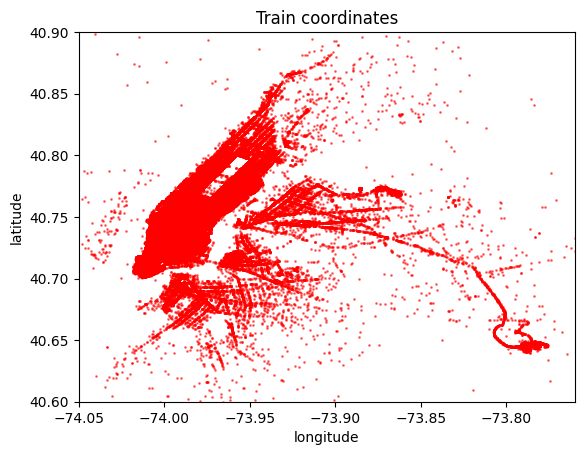

In [40]:
# Visualise PickUp Locations Density by plotting corresponding Longitudes/Latitudes

fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train_data['pickup_longitude'].values[:625134], train_data['pickup_latitude'].values[:625134],
              color='red', s=1, label='train', alpha=0.5)

ax.title.set_text('Train coordinates')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.xlim(-74.05, -73.76)
plt.ylim(40.60, 40.90)
plt.show()

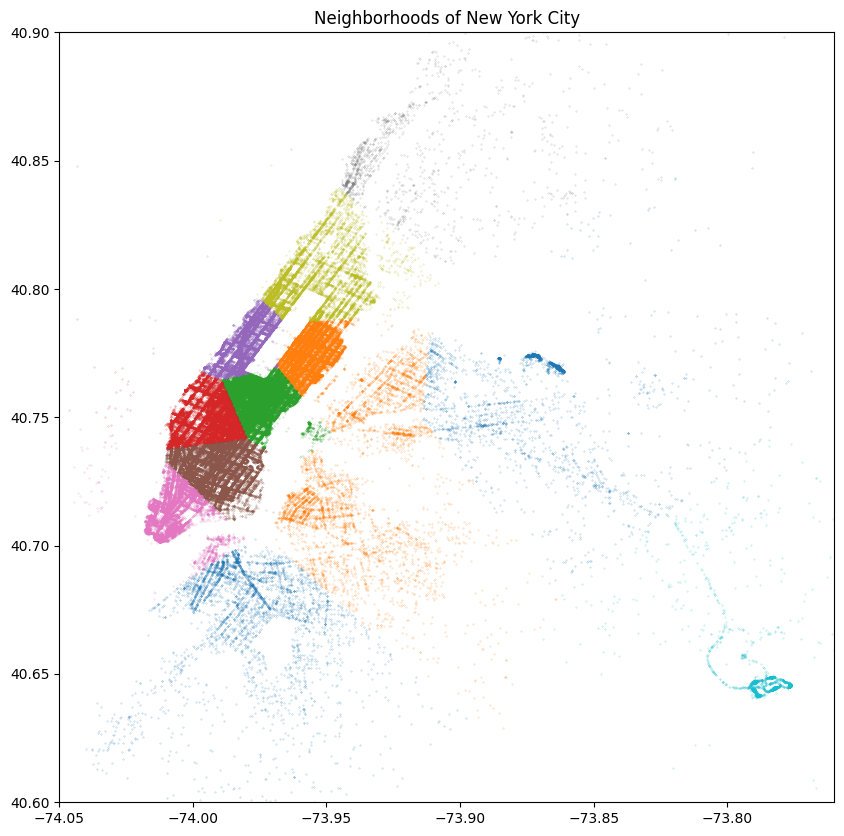

In [41]:
# Visualise main Neighbourhoods of New York City

from sklearn.cluster import KMeans

coordinates_df = pd.DataFrame()
coordinates_df['all_longitude'] = list(train_data.pickup_longitude) + list(train_data.dropoff_longitude)
coordinates_df['all_latitude'] = list(train_data.pickup_latitude) + list(train_data.dropoff_latitude)

kmeans = KMeans(n_clusters=20, random_state=2, n_init = 10).fit(coordinates_df)
coordinates_df['kmeans_label'] = kmeans.labels_

coordinates_df = coordinates_df.sample(200000)
plt.figure(figsize = (10,10))
for label in coordinates_df.kmeans_label.unique():
    plt.plot(coordinates_df.all_longitude[coordinates_df.kmeans_label == label],coordinates_df.all_latitude[coordinates_df.kmeans_label == label],'.', alpha = 0.5, markersize = 0.5)

plt.title('Neighborhoods of New York City')
plt.xlim(-74.05, -73.76)
plt.ylim(40.60, 40.90)
plt.show()

In [42]:
# Use folium to visualize pickup and dropoff points in New York

import folium
f = folium.Figure(width=1500, height=500)
mapa = folium.Map(location = (40.7679, -73.9822), zoom_start=11).add_to(f)

for index, row in train_data.sample(1000).iterrows():
    folium.Marker([row["pickup_latitude"], row["pickup_longitude"]], icon=folium.Icon(color="blue")).add_to(mapa)
    folium.Marker([row["dropoff_latitude"], row["dropoff_longitude"]], icon=folium.Icon(color="red")).add_to(mapa)


display(mapa)

In [43]:
# OSRM Dataset
fr1 = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/craftrip-594f5.appspot.com/o/fastest_routes_train_part_1.csv?alt=media&token=9b1832f8-2654-4835-9621-265e4f1f4c58', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps', ])
fr2 = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/craftrip-594f5.appspot.com/o/fastest_routes_train_part_2.csv?alt=media&token=26cc43e2-a68f-447c-9c9b-80255bb620d1', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/craftrip-594f5.appspot.com/o/fastest_routes_test.csv?alt=media&token=dd7ff2fe-ea90-46d9-8189-e0defbdf8955',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

In [44]:
fr1.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [45]:
fr2.describe()

,total_distance,total_travel_time,number_of_steps
count,758643.000000,758643.000000,758643.000000
mean,6557.779501,500.331713,9.331841
std,6635.023113,376.080521,5.121613
min,0.000000,0.000000,2.000000
25%,2066.800000,221.300000,5.000000
50%,4023.200000,388.200000,8.000000
75%,8678.900000,680.200000,13.000000
max,94204.200000,5135.400000,46.000000


In [46]:
test_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id0771704,1497.1,200.2,7
1,id3274209,1427.1,141.5,2
2,id2756455,2312.3,324.6,9
3,id3684027,931.8,84.2,4
4,id3101285,2501.7,294.7,8


In [47]:
# Concatenate both the OSRM datasets

train_street_info = pd.concat((fr1, fr2))
numeric_data = train_street_info[['total_distance', 'total_travel_time', 'number_of_steps']]
# sns.pairplot(data = numeric_data)

In [48]:
# Merge the train and test dataset with the OSRM Dataset
train_data = train_data.merge(train_street_info, how='left', on='id')
test_data = test_data.merge(test_street_info, how='left', on='id')

In [49]:
# Read in the weather dataset
weather_data = pd.read_csv('https://firebasestorage.googleapis.com/v0/b/pizzarush-40b2f.appspot.com/o/weather_data_nyc_centralpark_2016(1).csv?alt=media&token=a6fb7ce8-b4bc-4bc5-ac07-132a078bea85') # Replace with firebase link when available
weather_data.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0
3,4-1-2016,36,14,25.0,0.00,0.0,0
4,5-1-2016,29,11,20.0,0.00,0.0,0


In [50]:
weather_data.describe()

,maximum temperature,minimum temperature,average temperature
count,366.000000,366.000000,366.000000
mean,64.625683,49.806011,57.215847
std,18.041787,16.570747,17.124760
min,15.000000,-1.000000,7.000000
25%,50.000000,37.250000,44.000000
50%,64.500000,48.000000,55.750000
75%,81.000000,65.000000,73.500000
max,96.000000,81.000000,88.500000


In [51]:
weather_data.dtypes

date                    object
maximum temperature      int64
minimum temperature      int64
average temperature    float64
precipitation           object
snow fall               object
snow depth              object
dtype: object

In [52]:
# Convert the data values to float which could be plotted and convert the string values containing 'T' for 'Trace' to 0.00

import matplotlib.pyplot as plt
%matplotlib inline

weather_data.loc[weather_data['precipitation']== 'T', 'precipitation'] = '0.00'
weather_data['precipitation'] = (weather_data['precipitation']).astype(float)

weather_data.loc[weather_data['snow fall']== 'T', 'snow fall'] = '0.00'
weather_data['snow fall'] = (weather_data['snow fall']).astype(float)

weather_data.loc[weather_data['snow depth']== 'T', 'snow depth'] = '0.00'
weather_data['snow depth'] = (weather_data['snow depth']).astype(float)

In [53]:
weather_data['date'] = pd.to_datetime(weather_data.date, format='%d-%m-%Y')
weather_data['weather_dayofyear'] = weather_data.date.dt.dayofyear

# weather_data['date'] = pd.to_datetime(weather_data.date, format='%d/%m/%Y')
# weather_data['date'] = pd.to_datetime(weather_data.date)
# weather_data['weather_dayofyear']= weather_data.date.dt.dayofyear



In [54]:
# Plot min (yellow), avg (orange), and max (red) temperatures over time

import plotly.express as px
import plotly.graph_objects as go

# plotly.graph_objects
colors = ['yellow', 'orange', 'red']
fig = go.Figure()
fig.add_traces(go.Scatter(x=weather_data['date'], y = weather_data['minimum temperature'], mode = 'lines', line=dict(color=colors[0])))
fig.add_traces(go.Scatter(x=weather_data['date'], y = weather_data['average temperature'], mode = 'lines', line=dict(color=colors[1])))
fig.add_traces(go.Scatter(x=weather_data['date'], y = weather_data['maximum temperature'], mode = 'lines', line=dict(color=colors[2])))
fig.show()

In [55]:
# Plot precipitation, snow fall, and snow depth

import plotly as py
import plotly.graph_objs as go
import plotly

x_data = weather_data['date'].values
y0_data = weather_data['precipitation']
y1_data = weather_data['snow fall']
y2_data = weather_data['snow depth']

data0 = go.Scatter(
    x = x_data,
    y = y0_data,
    mode = 'markers',
    name = 'precipitation'
)
data1 = go.Scatter(
    x = x_data,
    y = y1_data,
    mode = 'markers',
    name = 'snow fall'
)
data2 = go.Scatter(
    x = x_data,
    y = y2_data,
    mode = 'markers',
    name = 'snow depth'
)

data = [data0, data1, data2]
plotly.offline.iplot(data, filename='scatter-mode')

In [56]:
# Merge train dataset with the weather dataset through date column
train_data['date'] = train_data['pickup_datetime'].dt.date
train_data['date'] = pd.to_datetime(train_data['date'])
weather = weather_data[['date','minimum temperature', 'precipitation', 'snow fall', 'snow depth']]
train_data = train_data.merge(weather, how='left', left_on='date', right_on='date')

In [57]:
# Merge test dataset with the weather dataset through date column
test_data['date'] = test_data['pickup_datetime'].dt.date
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.merge(weather, how='left', left_on='date', right_on='date')

In [58]:
# PCA - Reducing the dimentionality of the features

from sklearn.decomposition import PCA

coords = np.vstack((train_data[['pickup_latitude', 'pickup_longitude']].values,
                    train_data[['dropoff_latitude', 'dropoff_longitude']].values,
                    test_data[['pickup_latitude', 'pickup_longitude']].values,
                    test_data[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords) # fit the PCA model according to the coordinate values

In [59]:
# train_pca = pca.transform(train_data[['pickup_latitude', 'pickup_longitude']])
# test_pca = pca.transform(test_data[['pickup_latitude', 'pickup_longitude']])

# train_data['pickup_pca0'] = train_pca[:, 0]
# train_data['pickup_pca1'] = train_pca[:, 1]
# # train_data['dropoff_pca0'] = train_pca[:, 2]

# # train_data['dropoff_pca0'] = train_pca[:, 2]
# train_data['dropoff_pca1'] = train_pca[:, 3]

# test_data['pickup_pca0'] = test_pca[:, 0]
# test_data['pickup_pca1'] = test_pca[:, 1]
# test_data['dropoff_pca0'] = test_pca[:, 2]
# test_data['dropoff_pca1'] = test_pca[:, 3]

train_data['pickup_pca0'] = pca.transform(train_data[['pickup_latitude', 'pickup_longitude']])[:, 0] # Derive the PCA feature for Pickup Latitude in Train Dataset
train_data['pickup_pca1'] = pca.transform(train_data[['pickup_latitude', 'pickup_longitude']])[:, 1] # Derive the PCA feature for Pickup Longitude in Train Dataset
train_data['dropoff_pca0'] = pca.transform(train_data[['dropoff_latitude', 'dropoff_longitude']])[:, 0] # Derive the PCA feature for Dropoff Latitude in Train Dataset
train_data['dropoff_pca1'] = pca.transform(train_data[['dropoff_latitude', 'dropoff_longitude']])[:, 1] # Derive the PCA feature for Dropoff Longitude in Train Dataset
test_data['pickup_pca0'] = pca.transform(test_data[['pickup_latitude', 'pickup_longitude']])[:, 0] # Derive the PCA feature for Pickup Latitude in Test Dataset
test_data['pickup_pca1'] = pca.transform(test_data[['pickup_latitude', 'pickup_longitude']])[:, 1] # Derive the PCA feature for Pickup Longitude in Test Dataset
test_data['dropoff_pca0'] = pca.transform(test_data[['dropoff_latitude', 'dropoff_longitude']])[:, 0] # Derive the PCA feature for Dropoff Latitude in Test Dataset
test_data['dropoff_pca1'] = pca.transform(test_data[['dropoff_latitude', 'dropoff_longitude']])[:, 1] # Derive the PCA feature for Dropoff Longitutde in Test Dataset

train_data.loc[:, 'pca_manhattan'] = np.abs(train_data['dropoff_pca1'] - train_data['pickup_pca1']) + np.abs(train_data['dropoff_pca0'] - train_data['pickup_pca0']) # Calculate the Manhattan Distance with PCA Coordinates for Train Dataset
test_data.loc[:, 'pca_manhattan'] = np.abs(test_data['dropoff_pca1'] - test_data['pickup_pca1']) + np.abs(test_data['dropoff_pca0'] - test_data['pickup_pca0']) #Calculate the Manhattan Distance with PCA Coordinated for Test Dataset

train_pca = pca.transform(train_data[['pickup_latitude', 'pickup_longitude']])
test_pca = pca.transform(test_data[['pickup_latitude', 'pickup_longitude']])


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but PCA was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but PCA was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but PCA was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but PCA was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but PCA was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but PCA was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but PCA was fitted without feature names

/usr/local/lib/python3.10/dist-pac

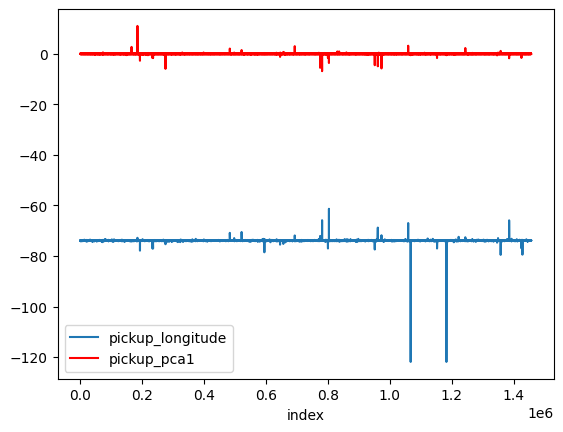

In [60]:
# Visualising a PCA Feature - Pickup Longitude (pickup_pca1) from Train Dataset

ax = plt.gca()

train_data.reset_index().plot(kind='line', x='index', y='pickup_longitude',ax=ax)
train_data.reset_index().plot(kind='line', x='index', y='pickup_pca1', color='red', ax=ax)

plt.show()

In [61]:
sample_ind = np.random.permutation(len(coords))[:500000]
# kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000, n_init=3).fit(coords[sample_ind])


In [62]:
# train_data.loc[:, 'pickup_cluster'] = kmeans.predict(train_data[['pickup_latitude', 'pickup_longitude']])
# train_data.loc[:, 'dropoff_cluster'] = kmeans.predict(train_data[['dropoff_latitude', 'dropoff_longitude']])
# test_data.loc[:, 'pickup_cluster'] = kmeans.predict(test_data[['pickup_latitude', 'pickup_longitude']])
# test_data.loc[:, 'dropoff_cluster'] = kmeans.predict(test_data[['dropoff_latitude', 'dropoff_longitude']])
train_data.loc[:, 'pickup_cluster'] = kmeans.predict(train_data[['pickup_latitude', 'pickup_longitude']].values)
train_data.loc[:, 'dropoff_cluster'] = kmeans.predict(train_data[['dropoff_latitude', 'dropoff_longitude']].values)
test_data.loc[:, 'pickup_cluster'] = kmeans.predict(test_data[['pickup_latitude', 'pickup_longitude']].values)
test_data.loc[:, 'dropoff_cluster'] = kmeans.predict(test_data[['dropoff_latitude', 'dropoff_longitude']].values)


In [63]:
# Listing out the features that should be used for training the XGB Model.
# print(train_data.columns)
feature_names = list(train_data.columns)
features_not_used = ['id', 'trip_duration_normalised', 'trip_duration', 'dropoff_datetime','dropoff_date','dropoff_hour',
                           'dropoff_month','dropoff_time','dropoff_weekday', 'pickup_date', 'pickup_datetime', 'date','pickup_time','pickup_month']
feature_names = [f for f in train_data.columns if f not in features_not_used]
train_data[feature_names].count()

vendor_id              1456476
passenger_count        1456476
pickup_longitude       1456476
pickup_latitude        1456476
dropoff_longitude      1456476
dropoff_latitude       1456476
store_and_fwd_flag     1456476
pickup_weekday         1456476
pickup_weekofyear      1456476
pickup_hour            1456476
pickup_minute          1456476
pickup_dt              1456476
pickup_week_hour       1456476
pickup_dayofyear       1456476
pickup_holiday         1456476
pickup_near_holiday    1456476
direction              1456476
distance_haversine     1456476
distance_manhattan     1456476
center_latitude        1456476
center_longitude       1456476
total_distance         1456475
total_travel_time      1456475
number_of_steps        1456475
minimum temperature    1456476
precipitation          1456476
snow fall              1456476
snow depth             1456476
pickup_pca0            1456476
pickup_pca1            1456476
dropoff_pca0           1456476
dropoff_pca1           1456476
pca_manh

In [64]:
# Performing k-fold splits

X = train_data[feature_names].values
y = np.log(train_data['trip_duration'].values + 1)
kf = KFold(n_splits=10)
kf.get_n_splits(X)

print(kf)

KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

KFold(n_splits=10, random_state=None, shuffle=False)
TRAIN: [ 145648  145649  145650 ... 1456473 1456474 1456475] TEST: [     0      1      2 ... 145645 145646 145647]
TRAIN: [      0       1       2 ... 1456473 1456474 1456475] TEST: [145648 145649 145650 ... 291293 291294 291295]
TRAIN: [      0       1       2 ... 1456473 1456474 1456475] TEST: [291296 291297 291298 ... 436941 436942 436943]
TRAIN: [      0       1       2 ... 1456473 1456474 1456475] TEST: [436944 436945 436946 ... 582589 582590 582591]
TRAIN: [      0       1       2 ... 1456473 1456474 1456475] TEST: [582592 582593 582594 ... 728237 728238 728239]
TRAIN: [      0       1       2 ... 1456473 1456474 1456475] TEST: [728240 728241 728242 ... 873885 873886 873887]
TRAIN: [      0       1       2 ... 1456473 1456474 1456475] TEST: [ 873888  873889  873890 ... 1019532 1019533 1019534]
TRAIN: [      0       1       2 ... 1456473 1456474 1456475] TEST: [1019535 1019536 1019537 ... 1165179 1165180 1165181]
TRAIN: [      0

In [65]:
# Setting the XGB Parameters
# print(test_data.columns)
# print(feature_names)
test_data['pickup_weekofyear'] = train_data['pickup_datetime'].dt.isocalendar().week
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(test_data[feature_names].values)
print(test_data.columns)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_parameters = {'min_child_weight': 10, 'eta': 0.04, 'colsample_bytree': 0.8, 'max_depth': 15,
            'subsample': 0.75, 'lambda': 2, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 'gamma' : 0,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'pickup_date', 'pickup_time',
       'pickup_weekday', 'pickup_hour', 'pickup_minute', 'pickup_dt',
       'pickup_week_hour', 'pickup_dayofyear', 'pickup_month',
       'pickup_holiday', 'pickup_near_holiday', 'direction',
       'distance_haversine', 'distance_manhattan', 'center_latitude',
       'center_longitude', 'total_distance', 'total_travel_time',
       'number_of_steps', 'date', 'minimum temperature', 'precipitation',
       'snow fall', 'snow depth', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0',
       'dropoff_pca1', 'pca_manhattan', 'pickup_cluster', 'dropoff_cluster',
       'pickup_weekofyear'],
      dtype='object')


In [66]:
# Training the model
# evals = [(dtrain, 'train'), (dval, 'validation')]
# model = xgb.train(xgb_parameters, dtrain, num_boost_round=750, evals=evals, early_stopping_rounds=250, maximize=False, verbose_eval=15)


model = xgb.train(xgb_parameters, dtrain, 750, watchlist, early_stopping_rounds=250, maximize=False, verbose_eval=15)

[16:19:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:26] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning:

Pass `evals` as keyword args.



[0]	train-rmse:5.77092	valid-rmse:5.77192
[15]	train-rmse:3.14573	valid-rmse:3.14700
[30]	train-rmse:1.73229	valid-rmse:1.73480
[45]	train-rmse:0.98132	valid-rmse:0.98717
[60]	train-rmse:0.59567	valid-rmse:0.60865
[75]	train-rmse:0.41130	valid-rmse:0.43505
[90]	train-rmse:0.33107	valid-rmse:0.36562
[105]	train-rmse:0.29791	valid-rmse:0.34080
[120]	train-rmse:0.28253	valid-rmse:0.33173
[135]	train-rmse:0.27396	valid-rmse:0.32822
[150]	train-rmse:0.26825	valid-rmse:0.32650
[165]	train-rmse:0.26349	valid-rmse:0.32545
[180]	train-rmse:0.25861	valid-rmse:0.32441
[195]	train-rmse:0.25490	valid-rmse:0.32374
[210]	train-rmse:0.25240	valid-rmse:0.32330
[225]	train-rmse:0.24972	valid-rmse:0.32278
[240]	train-rmse:0.24764	valid-rmse:0.32236
[255]	train-rmse:0.24496	valid-rmse:0.32185
[270]	train-rmse:0.24306	valid-rmse:0.32160
[285]	train-rmse:0.24123	valid-rmse:0.32138
[300]	train-rmse:0.23940	valid-rmse:0.32116
[315]	train-rmse:0.23685	valid-rmse:0.32077
[330]	train-rmse:0.23505	valid-rmse:0.32

In [67]:
# Predicting the model on test data

y_test = model.predict(dtest)
y_pred = model.predict(dvalid)

Number of rows for test data and predicted data are same
Valid prediction mean: 6.461
Test prediction mean: 6.458


<ipython-input-68-ffc9e3e7115f>:15: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-68-ffc9e3e7115f>:16: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




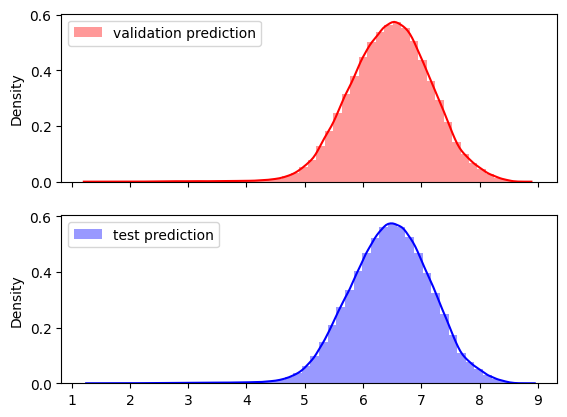

In [68]:
# Check the number of rows of test data to be matching with predicted data.
if test_data.shape[0] == y_test.shape[0]:
  print('Number of rows for test data and predicted data are same')
else:
  print('Error in Test Data Format')

# Convert predicted dataframe into a csv file for submission
test_data['trip_duration'] = np.exp(y_test) - 1
test_data[['id', 'trip_duration']].to_csv('final_submission.csv', index=False)

# Plot validation and test prediction mean
print('Valid prediction mean: %.3f' % y_pred.mean())
print('Test prediction mean: %.3f' % y_test.mean())
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(y_pred, ax=ax[0], color='red', label='validation prediction')
sns.distplot(y_test, ax=ax[1], color='blue', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()